In [1]:
# imports
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## plot on the multimers convertered to monomeric assemblies 

In [2]:
# read in the phrogs annotations so that these can be overlayed 
phrogs_df = pd.read_csv('/home/grig0076/scratch/databases/phrogs/phrog_annot_v4.tsv', sep='\t')
phrogs_df['phrog']  = ['phrog_' + str(p) for p in phrogs_df['phrog']] 
phrogs_category = dict(zip(phrogs_df['phrog'], phrogs_df['category']))
phrogs_annot = dict(zip(phrogs_df['phrog'], phrogs_df['annot']))

In [3]:
# read in the multimer single chain results 
multimer_single_chain = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/one_chain_pairs', sep = '\t', header=None)
multimer_single_chain.columns = ["query","target","qtmscore","ttmscore","alntmscore"]

multimer_single_chain['query'] = [re.split('\.',q)[0] for q in multimer_single_chain['query']]
multimer_single_chain['target'] = [re.split('\.',q)[0] for q in multimer_single_chain['target']]


In [4]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

df = multimer_single_chain.copy()
df["qtmscore"] = df["qtmscore"].astype(float)
df["ttmscore"] = df["ttmscore"].astype(float)

# ----- build symmetric similarity per unordered pair -----
# similarity = mean(qTM, tTM)
df["sim"] = (df["qtmscore"] + df["ttmscore"]) / 2.0

# canonicalize pair so (A,B) == (B,A)
ab = np.sort(df[["query", "target"]].to_numpy(), axis=1)
df["a"] = ab[:, 0]
df["b"] = ab[:, 1]

# keep the best (max) similarity per unordered pair
best = (df.groupby(["a", "b"], as_index=False)["sim"]
          .max())

# full ID list (square matrix)
ids = sorted(set(best["a"]).union(best["b"]))

# upper-tri similarity matrix
sim = (best.pivot(index="a", columns="b", values="sim")
           .reindex(index=ids, columns=ids))

# mirror to make symmetric; set self-similarity = 1
sim_full = sim.combine_first(sim.T)
np.fill_diagonal(sim_full.values, 1.0)

# ----- convert to distance -----
# distance = 1 - similarity; fill missing with max distance (1.0)
D = (1.0 - sim_full).fillna(1.0).astype("float32")
np.fill_diagonal(D.values, 0.0)

# ----- t-SNE on precomputed distances -----
tsne = TSNE(
    n_components=2,
    metric='precomputed',
    perplexity=50,          # try 30–100 for ~6k items
    n_iter=2000,
    learning_rate='auto',
    random_state=42,
    init='random',          # can't use 'pca' with precomputed distances
)

embedding = tsne.fit_transform(D.values)

# tidy DataFrame
tsne_df = pd.DataFrame(embedding, columns=["TSNE1", "TSNE2"], index=ids).reset_index()
tsne_df = tsne_df.rename(columns={"index": "phrog"})



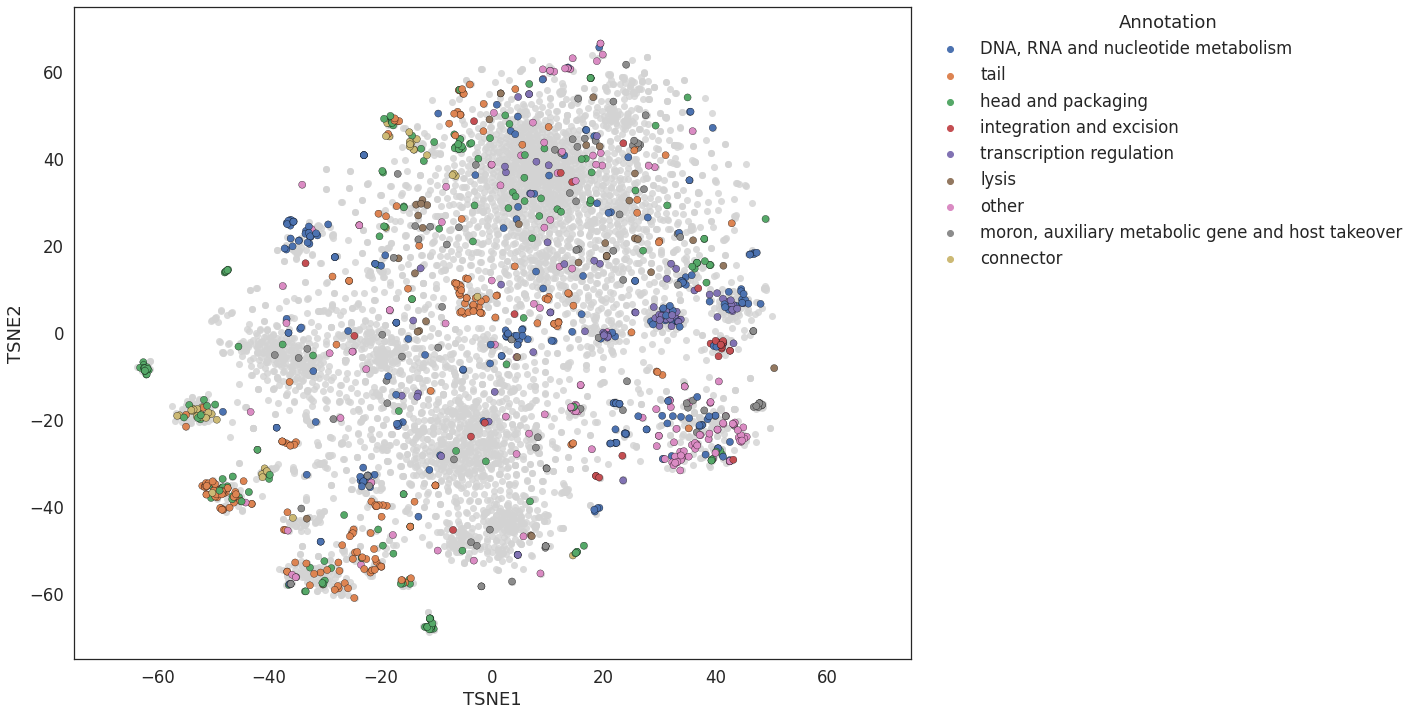

In [6]:
tsne_df['category'] = [phrogs_category.get(p) for p in tsne_df['phrog']]
tsne_df['annot'] = [phrogs_annot.get(p) for p in tsne_df['phrog']]


plt.figure(figsize=(15, 12))
sns.set(style="white", font_scale=1.5)
sns.scatterplot(data=tsne_df[tsne_df['category'] == 'unknown function'], x = 'TSNE1', y='TSNE2',  color='#d3d3d3', s=50, edgecolor='black', linewidth=0, alpha=0.8,
    legend='full')
sns.scatterplot(data=tsne_df[tsne_df['category'] != 'unknown function'], x = 'TSNE1', y='TSNE2', hue = 'category' ,s=50, edgecolor='black', linewidth=0.3,
    legend='full')
plt.xlim((-75, 75))
plt.ylim((-75, 75))

# Move legend to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation"
)

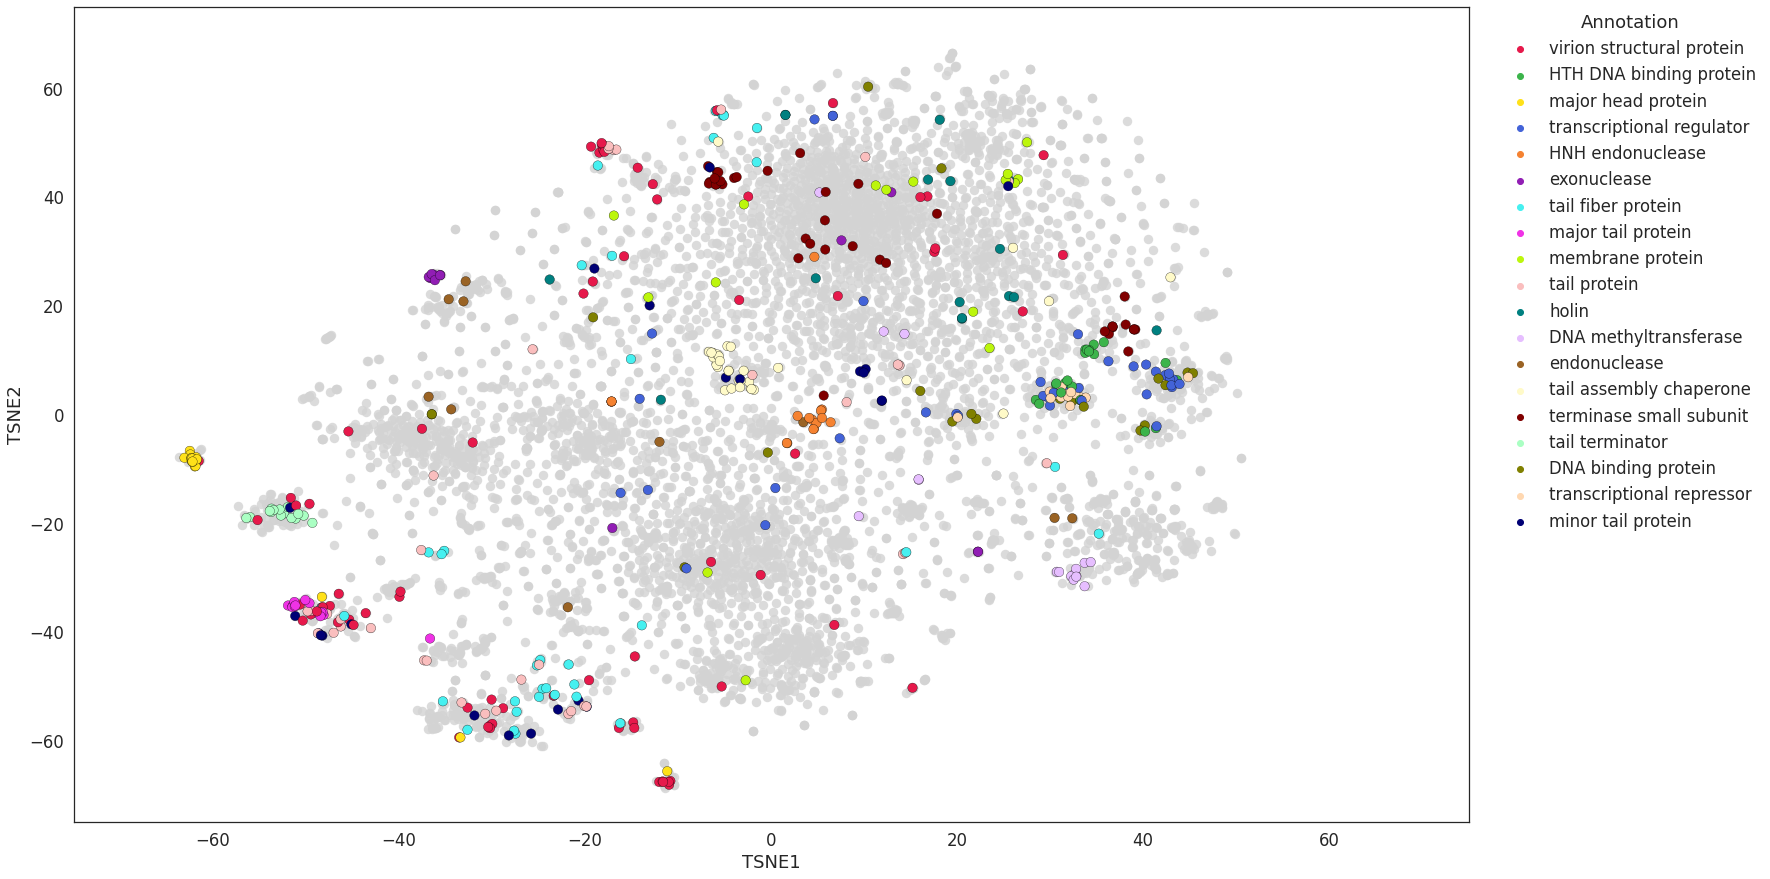

In [13]:
# just take top 20 anotations
top20_annotations = pd.DataFrame.from_dict(Counter(tsne_df['annot']), orient='index').sort_values(0, ascending=False).index[1:20].to_list() 
palette2 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075']
 
    
plt.figure(figsize=(25, 15))
sns.set(style="white", font_scale=1.5)
sns.scatterplot(data=tsne_df[~tsne_df['annot'].isin(top20_annotations)], x = 'TSNE1', y='TSNE2',  color='#d3d3d3', s=90, edgecolor='black', linewidth=0, alpha=0.8,
    legend='full')
sns.scatterplot(data=tsne_df[tsne_df['annot'].isin(top20_annotations)], x = 'TSNE1', y='TSNE2', hue = 'annot' ,s=90, edgecolor='black', linewidth=0.3,palette=palette2,
    legend='full')
plt.xlim((-75, 75))
plt.ylim((-75, 75))

# Move legend to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation"
)

# Save figure (high-resolution PNG)
plt.savefig("tsne_top20_annotations.png", dpi=300, bbox_inches="tight")


In [23]:
tsne_df[tsne_df['annot'] == 'tail protein'].sort_values('TSNE1')

,phrog,TSNE1,TSNE2,category,annot
265,phrog_11502,-51.268318,-35.255486,tail,tail protein
5324,phrog_4579,-49.834316,-36.180424,tail,tail protein
329,phrog_1182,-49.810242,-36.171692,tail,tail protein
4711,phrog_365,-49.403675,-36.074013,tail,tail protein
805,phrog_1424,-48.730732,-40.218719,tail,tail protein
5089,phrog_38654,-47.728786,-36.646679,tail,tail protein
5803,phrog_6305,-47.038445,-40.133804,tail,tail protein
6130,phrog_76,-46.281338,-37.644211,tail,tail protein
291,phrog_11649,-46.269516,-38.972839,tail,tail protein
559,phrog_12948,-43.031296,-39.269192,tail,tail protein


In [22]:
tsne_df[tsne_df['annot'] == 'tail fiber protein'].sort_values('TSNE1')

,phrog,TSNE1,TSNE2,category,annot
2711,phrog_2420,-48.337593,-35.561985,tail,tail fiber protein
6283,phrog_817,-45.892696,-37.048767,tail,tail fiber protein
1696,phrog_1858,-36.821568,-25.343151,tail,tail fiber protein
5953,phrog_6859,-35.427494,-25.675806,tail,tail fiber protein
418,phrog_12296,-35.290382,-52.735271,tail,tail fiber protein
1644,phrog_1833,-35.148354,-25.061790,tail,tail fiber protein
3130,phrog_26525,-32.645081,-57.981537,tail,tail fiber protein
2814,phrog_24754,-27.638531,-58.148342,tail,tail fiber protein
2737,phrog_24330,-27.535881,-52.738132,tail,tail fiber protein
2715,phrog_24210,-27.488091,-58.693226,tail,tail fiber protein


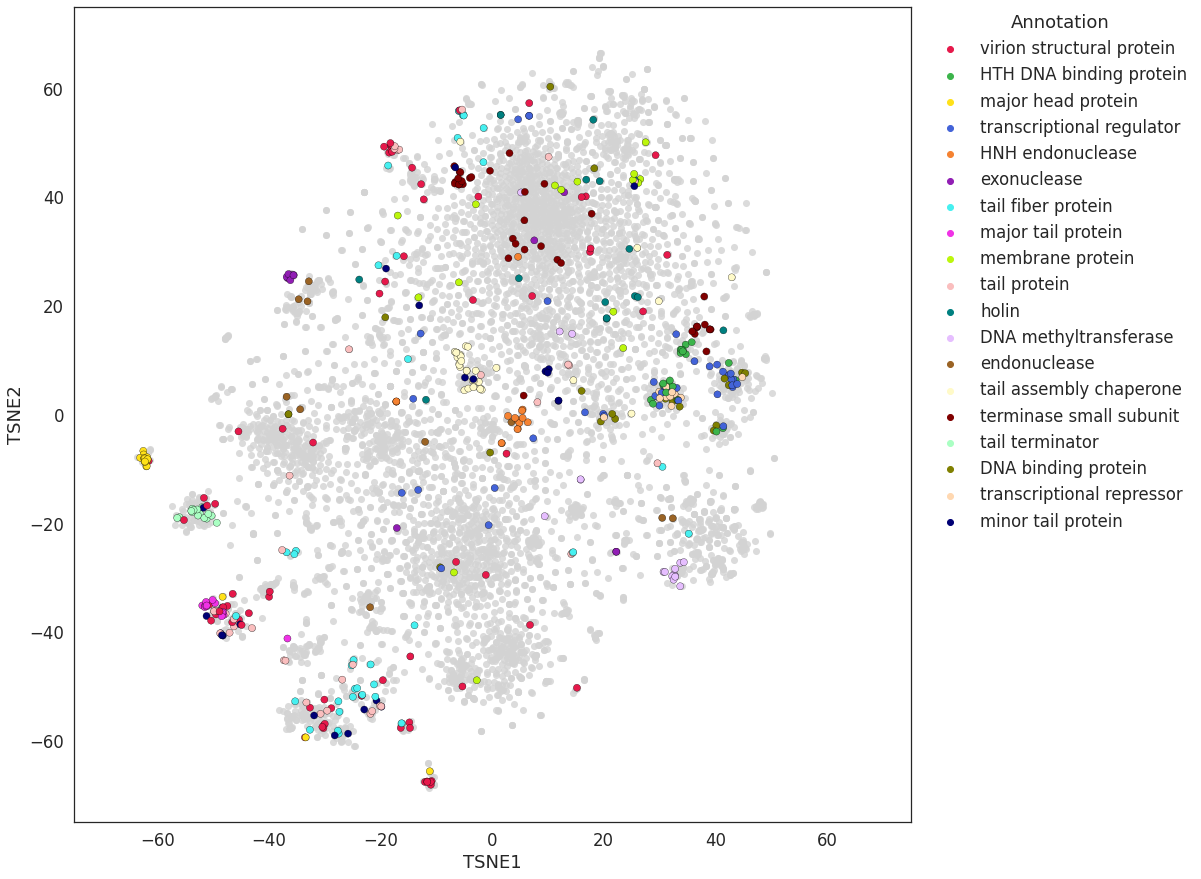

In [16]:
# just take top 20 anotations
top20_annotations = pd.DataFrame.from_dict(Counter(tsne_df['annot']), orient='index').sort_values(0, ascending=False).index[1:20].to_list() 
palette2 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075']
 
    
plt.figure(figsize=(15, 15))
sns.set(style="white", font_scale=1.5)
sns.scatterplot(data=tsne_df[~tsne_df['annot'].isin(top20_annotations)], x = 'TSNE1', y='TSNE2',  color='#d3d3d3', s=50, edgecolor='black', linewidth=0, alpha=0.8,
    legend='full')
sns.scatterplot(data=tsne_df[tsne_df['annot'].isin(top20_annotations)], x = 'TSNE1', y='TSNE2', hue = 'annot' ,s=50, edgecolor='black', linewidth=0.3,palette=palette2,
    legend='full')
plt.xlim((-75, 75))
plt.ylim((-75, 75))

# Move legend to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation"
)

## Repeat on the monomers

In [5]:
# read in the multimer single chain results 
monomer = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/foldseek_monomercluster/pairs', sep = '\t', header=None)
monomer.columns = ["query","target","qtmscore","ttmscore","alntmscore"]

monomer['query'] = [re.split('\.',q)[0] for q in monomer['query']]
monomer['target'] = [re.split('\.',q)[0] for q in monomer['target']]


In [6]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

df = monomer.copy()
df["qtmscore"] = df["qtmscore"].astype(float)
df["ttmscore"] = df["ttmscore"].astype(float)

# ----- build symmetric similarity per unordered pair -----
# similarity = mean(qTM, tTM)
df["sim"] = (df["qtmscore"] + df["ttmscore"]) / 2.0

# canonicalize pair so (A,B) == (B,A)
ab = np.sort(df[["query", "target"]].to_numpy(), axis=1)
df["a"] = ab[:, 0]
df["b"] = ab[:, 1]

# keep the best (max) similarity per unordered pair
best = (df.groupby(["a", "b"], as_index=False)["sim"]
          .max())

# full ID list (square matrix)
ids = sorted(set(best["a"]).union(best["b"]))

# upper-tri similarity matrix
sim = (best.pivot(index="a", columns="b", values="sim")
           .reindex(index=ids, columns=ids))

# mirror to make symmetric; set self-similarity = 1
sim_full = sim.combine_first(sim.T)
np.fill_diagonal(sim_full.values, 1.0)

# ----- convert to distance -----
# distance = 1 - similarity; fill missing with max distance (1.0)
D = (1.0 - sim_full).fillna(1.0).astype("float32")
np.fill_diagonal(D.values, 0.0)

# ----- t-SNE on precomputed distances -----
tsne = TSNE(
    n_components=2,
    metric='precomputed',
    perplexity=50,          # try 30–100 for ~6k items
    n_iter=2000,
    learning_rate='auto',
    random_state=42,
    init='random',          # can't use 'pca' with precomputed distances
)

embedding = tsne.fit_transform(D.values)

# tidy DataFrame
tsne_df = pd.DataFrame(embedding, columns=["TSNE1", "TSNE2"], index=ids).reset_index()
tsne_df = tsne_df.rename(columns={"index": "phrog"})



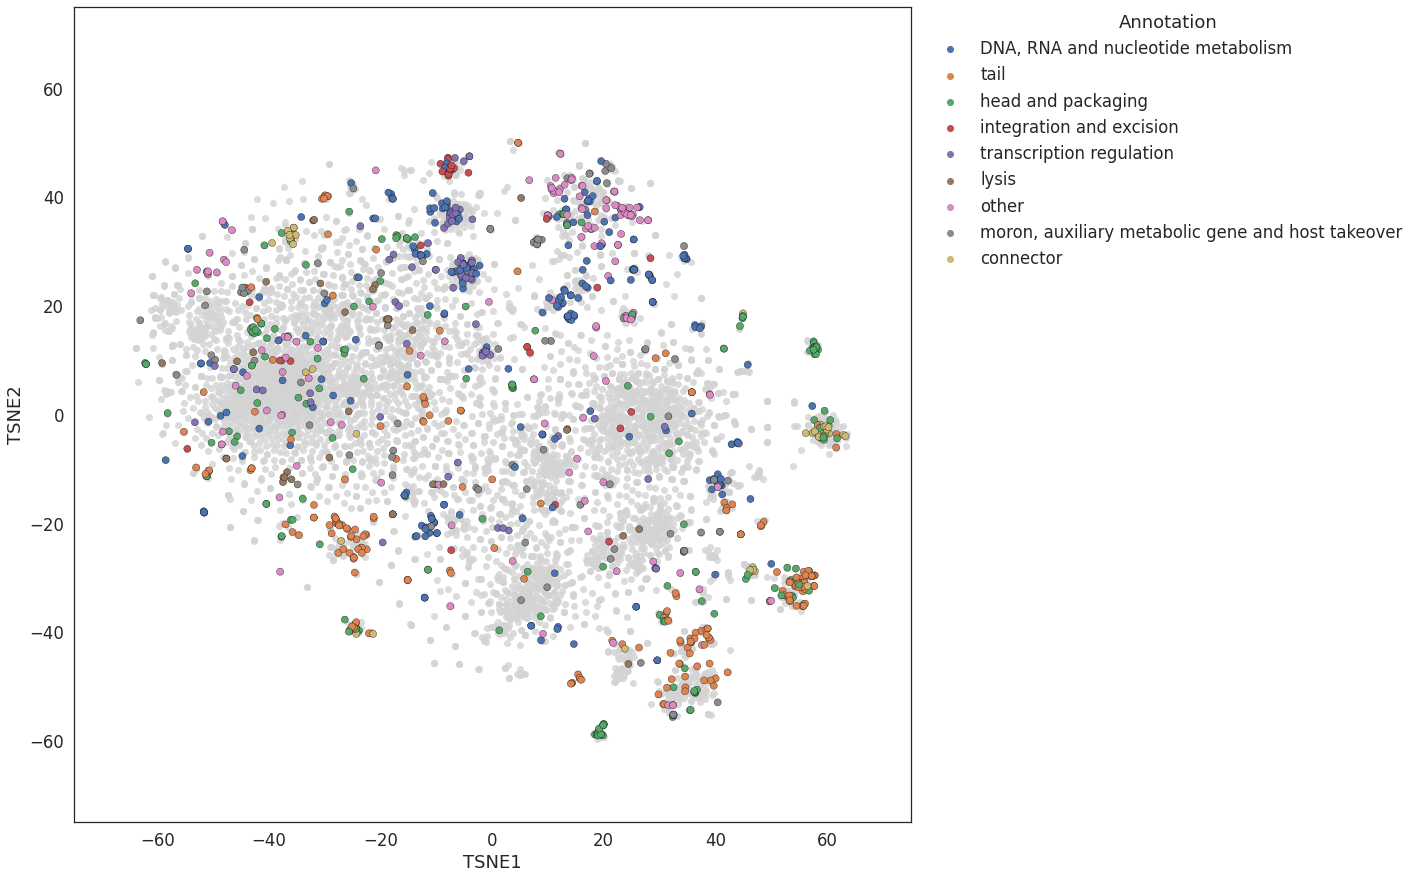

In [10]:
tsne_df['category'] = [phrogs_category.get(p) for p in tsne_df['phrog']]
tsne_df['annot'] = [phrogs_annot.get(p) for p in tsne_df['phrog']]


plt.figure(figsize=(15, 15))
sns.set(style="white", font_scale=1.5)
sns.scatterplot(data=tsne_df[tsne_df['category'] == 'unknown function'], x = 'TSNE1', y='TSNE2',  color='#d3d3d3', s=50, edgecolor='black', linewidth=0, alpha=0.8,
    legend='full')
sns.scatterplot(data=tsne_df[tsne_df['category'] != 'unknown function'], x = 'TSNE1', y='TSNE2', hue = 'category' ,s=50, edgecolor='black', linewidth=0.3,
    legend='full')
plt.xlim((-75, 75))
plt.ylim((-75, 75))

# Move legend to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation"
)

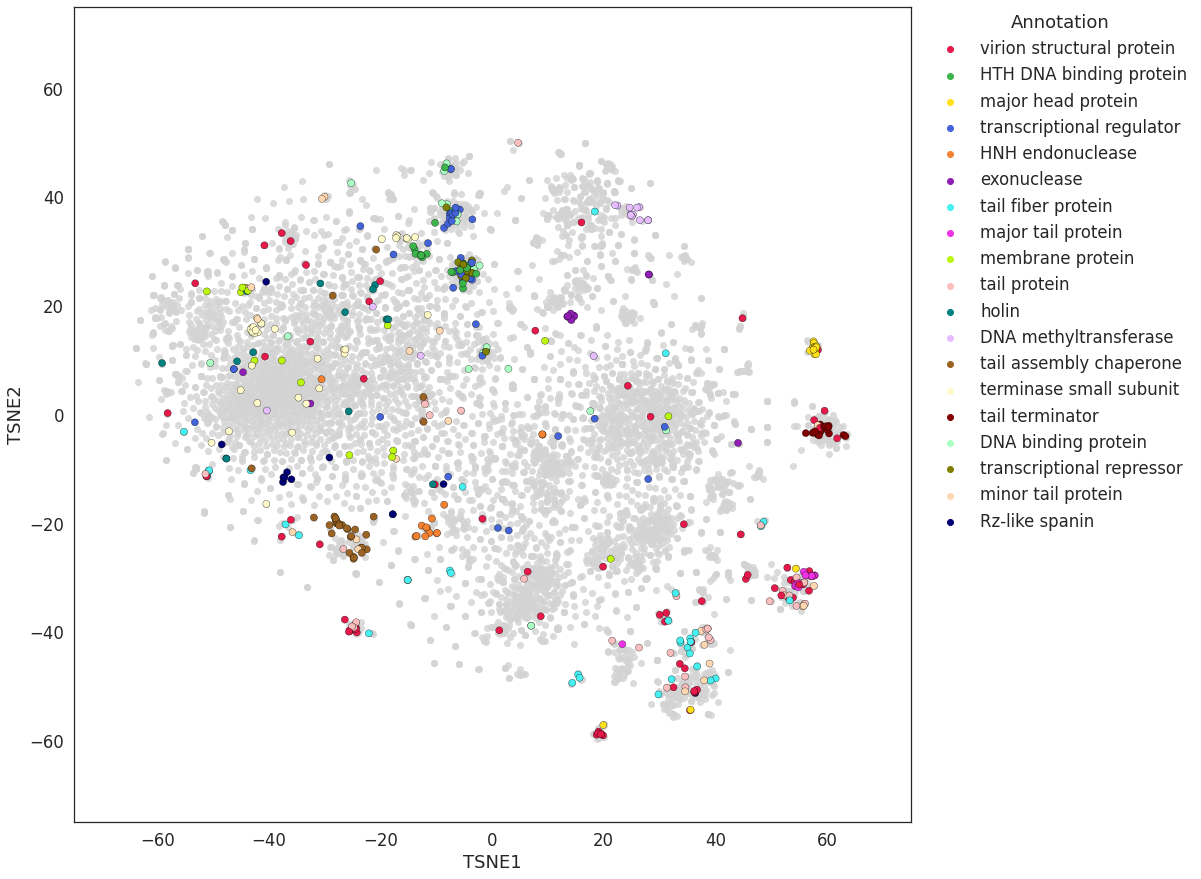

In [11]:
# just take top 20 anotations
top20_annotations = pd.DataFrame.from_dict(Counter(tsne_df['annot']), orient='index').sort_values(0, ascending=False).index[1:20].to_list() 
palette2 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075']
 
    
plt.figure(figsize=(15, 15))
sns.set(style="white", font_scale=1.5)
sns.scatterplot(data=tsne_df[~tsne_df['annot'].isin(top20_annotations)], x = 'TSNE1', y='TSNE2',  color='#d3d3d3', s=50, edgecolor='black', linewidth=0, alpha=0.8,
    legend='full')
sns.scatterplot(data=tsne_df[tsne_df['annot'].isin(top20_annotations)], x = 'TSNE1', y='TSNE2', hue = 'annot' ,s=50, edgecolor='black', linewidth=0.3,palette=palette2,
    legend='full')
plt.xlim((-75, 75))
plt.ylim((-75, 75))

# Move legend to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation"
)